In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

import cv2
import matplotlib.pyplot as plt
import random
import cv2
import matplotlib.pyplot as plt
import random
import torch
import torch.optim as optim
import numpy as np


In [2]:
if os.path.exists('goat.jpg'):
    print('goat.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

goat.jpg exists


torch.Size([3, 1226, 1080])


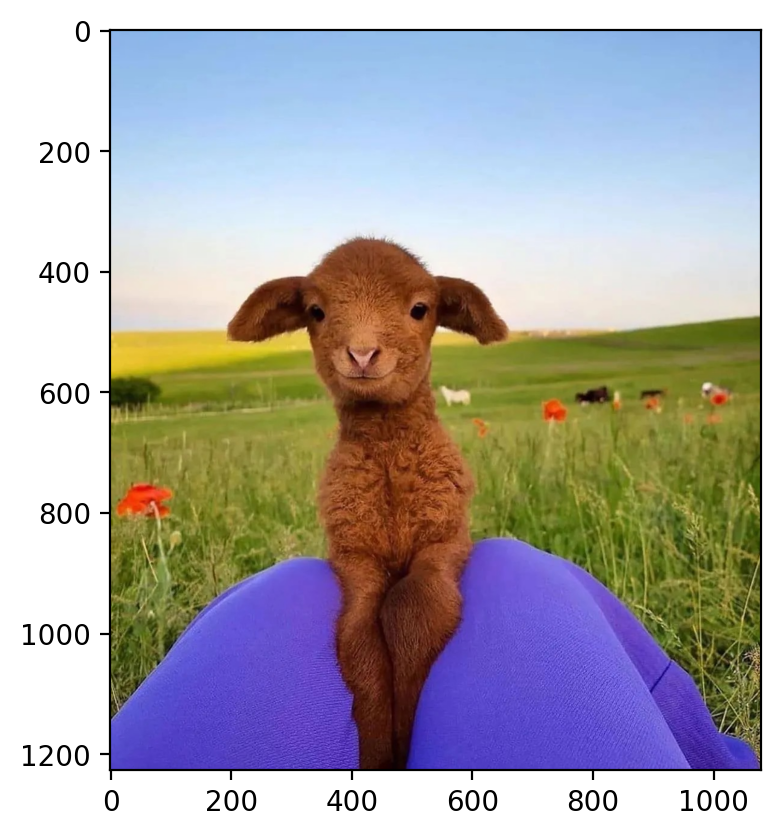

In [3]:
img = torchvision.io.read_image("goat.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [4]:
def read_image(image_path):
    image = cv2.imread('goat.jpg')
    if image is None:
        print("Error: Could not load image.")
        return None
    return image

In [5]:
def select_random_patch(image, patch_size=50):
    height, width, _ = image.shape
    x = random.randint(0, width - patch_size)
    y = random.randint(0, height - patch_size)
    return x, y


In [6]:
def extract_patch(image, x, y, patch_size=50):
    return image[y:y+patch_size, x:x+patch_size].copy()


In [7]:
def mask_patch(image, patch, x, y):
    masked_image = image.copy()
    masked_image[y:y+patch.shape[0], x:x+patch.shape[1]] = patch
    return masked_image

In [8]:
def reconstruct_patch(original_patch, r):
    patch_tensor = torch.tensor(original_patch, dtype=torch.float).permute(2, 0, 1)  # Shape: (3, 50, 50)
    
    for i in range(3):  # For each color channel
        W, H, loss = factorize(patch_tensor[i], r)
        patch_tensor[i] = torch.mm(W, H)

    reconstructed_patch = patch_tensor.permute(1, 2, 0).detach().numpy()
    return np.clip(reconstructed_patch, 0, 255).astype('uint8')  # Ensure valid pixel values


In [9]:
def factorize(A, r, device=torch.device("cpu")):
    A = A.to(device)
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    
    for i in range(5000):
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    
    return W, H, loss


In [10]:
def compute_rmse(original_patch, reconstructed_patch):
    original_patch = original_patch.astype(np.float32)
    reconstructed_patch = reconstructed_patch.astype(np.float32)
    return np.sqrt(np.mean((original_patch - reconstructed_patch) ** 2))

def compute_psnr(original_patch, reconstructed_patch):
    original_patch = original_patch.astype(np.float32)
    reconstructed_patch = reconstructed_patch.astype(np.float32)
    mse = np.mean((original_patch - reconstructed_patch) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr


In [11]:
def process_image(image_path, patch_size=50, ranks=[5, 10, 25, 50]):
    image = read_image(image_path)
    if image is None:
        return

    x, y = select_random_patch(image, patch_size)
    original_patch = extract_patch(image, x, y, patch_size)

    for r in ranks:
        # Reconstruct the patch using the current rank
        reconstructed_patch = reconstruct_patch(original_patch, r)
        
        # Create a masked image with the reconstructed patch
        masked_image = image.copy()
        masked_image[y:y+patch_size, x:x+patch_size] = reconstructed_patch

        # Display the results
        display_comparison(original_patch, reconstructed_patch)
        
        # Compute RMSE and PSNR
        rmse = compute_rmse(original_patch, reconstructed_patch)
        psnr = compute_psnr(original_patch, reconstructed_patch)
        
        print(f"Rank: {r} -> RMSE: {rmse:.2f}, PSNR: {psnr:.2f} dB")


In [14]:
def display_comparison(original_patch, reconstructed_patch):
    plt.figure(figsize=(8, 4))  # Increased width for more space between images

    # Display the original patch
    plt.subplot(1, 2, 1)
    plt.imshow(original_patch)
    plt.title("Original 50x50 Patch", fontsize=12)  # Reduced title font size
    plt.axis('on')  # Keep axis visible

    # Display the reconstructed patch
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_patch)
    plt.title("Reconstructed 50x50 Patch", fontsize=12)  # Reduced title font size
    plt.axis('on')  # Keep axis visible

    plt.subplots_adjust(wspace=0.5)  # Adjust space between the two subplots
    plt.show()


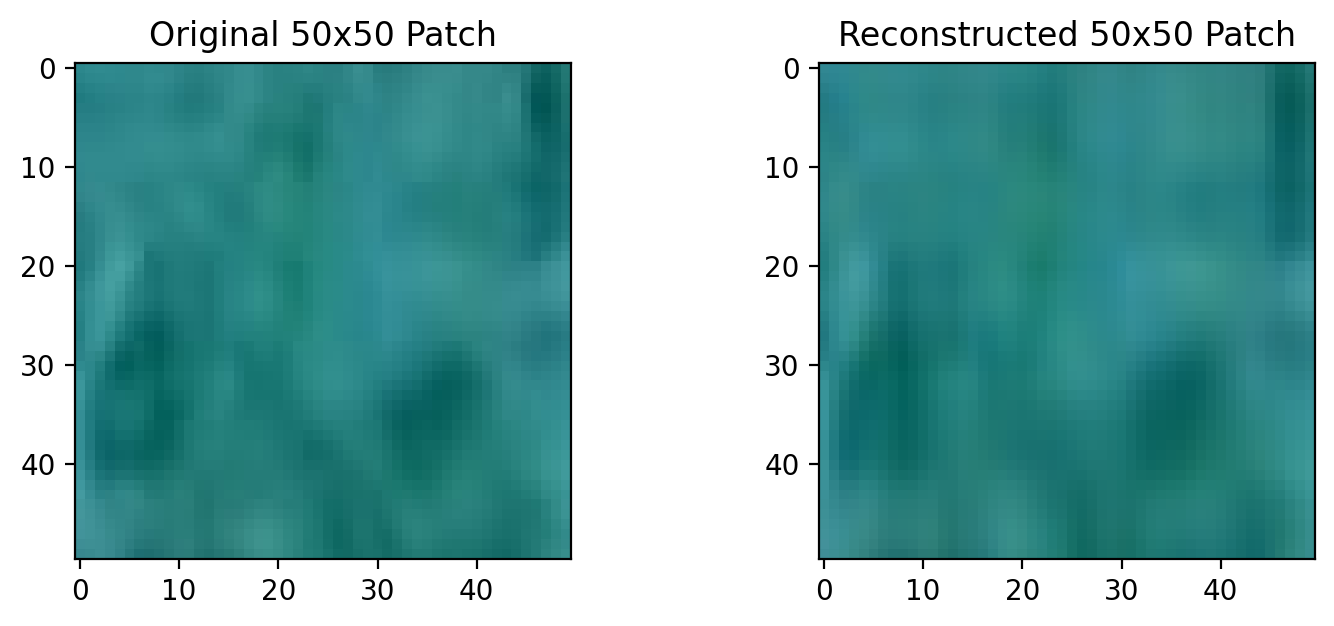

Rank: 5 -> RMSE: 3.58, PSNR: 37.06 dB


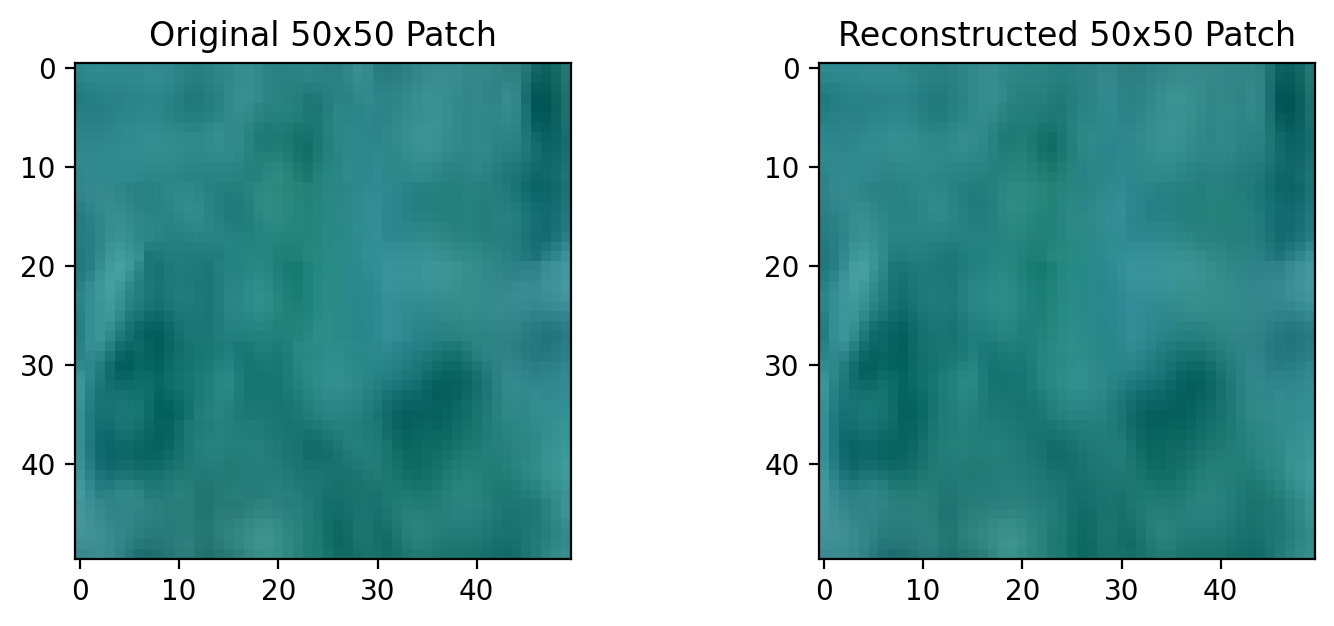

Rank: 10 -> RMSE: 1.39, PSNR: 45.28 dB


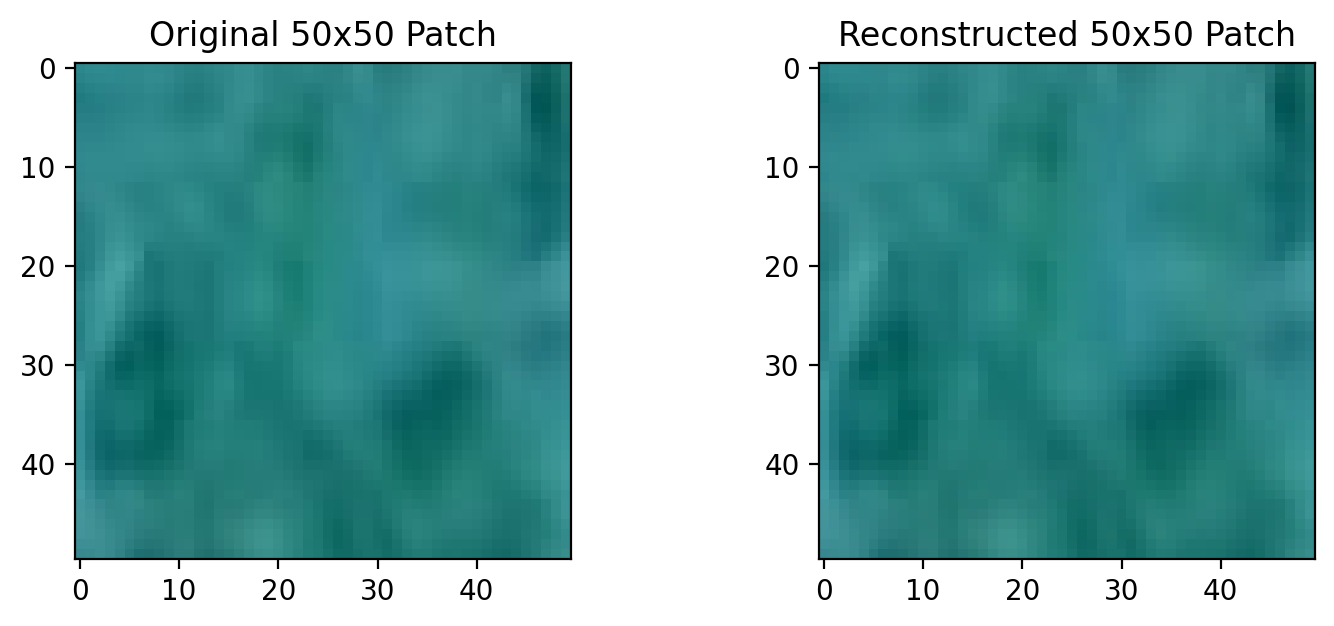

Rank: 25 -> RMSE: 0.71, PSNR: 51.06 dB


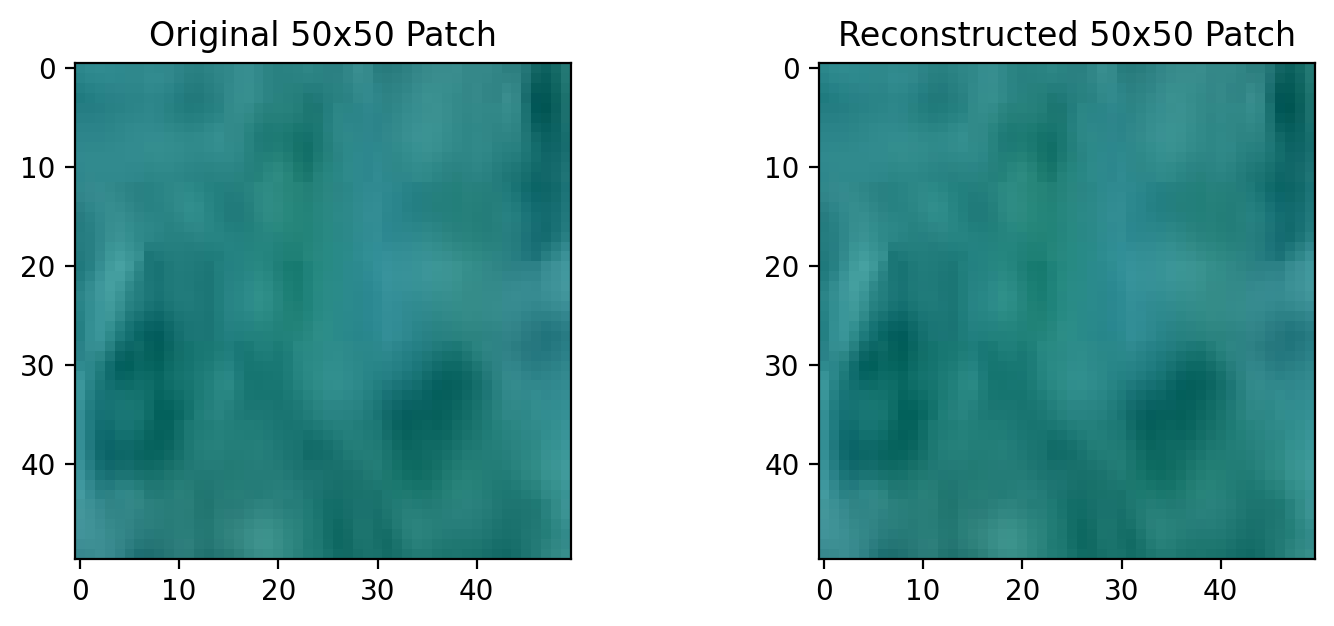

Rank: 50 -> RMSE: 0.81, PSNR: 49.92 dB


In [15]:
process_image('goat.jpg', patch_size=50, ranks=[5, 10, 25, 50])